In [46]:
from sklearn.model_selection import train_test_split, StratifiedKFold
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import numpy as np
from xgboost import XGBRegressor



In [47]:
df = pd.read_csv('final_dataset_encoded.csv', low_memory=False)
print(f"Original shape: {df.shape}")

df['year_index'] = pd.Series(df['academicYear']).rank(method='dense').astype(int)
df.set_index('year_index', inplace=True)

# # Display the DataFrame
# print("DataFrame with year index:")
# print(df.head())
df_2019 = df.loc[1]  # Based on your date format
print("DataFrame with year index 2019:" ,df_2019.head())


Original shape: (50554, 62)
DataFrame with year index 2019:             academicYear  universityName  faculty  departmentName  \
year_index                                                          
1                   2019               0      194             298   
1                   2019               0      201              36   
1                   2019               0      201              94   
1                   2019               0      201             107   
1                   2019               0      201             278   

                 idOSYM  scholarshipRate  quota  occupiedSlots  tuitionFee  \
year_index                                                                   
1           106510014.0                0     62             62         0.0   
1           106510077.0                0     62             62         0.0   
1           106510068.0                0     62             62         0.0   
1           106510023.0                0     62             62    

In [48]:
df.head()

,academicYear,universityName,faculty,departmentName,idOSYM,scholarshipRate,quota,occupiedSlots,tuitionFee,universityLocation,...,language_Ermenice,language_Fransızca,language_Korece,language_Lehçe,language_Rusça,language_Türkçe,language_Çince,language_İngilizce,language_İspanyolca,language_İtalyanca
year_index,,,,,,,,,,,,,,,,,,,,,
5,2023,0,194,298,106510014.0,0,70,72,0.0,41,...,0,0,0,0,0,0,0,1,0,0
4,2022,0,194,298,106510014.0,0,70,72,0.0,41,...,0,0,0,0,0,0,0,1,0,0
6,2024,0,194,298,106510014.0,0,60,62,0.0,41,...,0,0,0,0,0,0,0,1,0,0
2,2020,0,194,298,106510014.0,0,62,62,0.0,41,...,0,0,0,0,0,0,0,1,0,0
1,2019,0,194,298,106510014.0,0,62,62,0.0,41,...,0,0,0,0,0,0,0,1,0,0


In [49]:
def calculate_qerror(y_true, y_pred):
    """
    Calculate the quantile error (q-error) between the true and predicted values.

    Parameters:
    y_true (array-like): True values
    y_pred (array-like): Predicted values

    Returns:
    float: The quantile error
    """
    q_error = np.maximum(y_true / y_pred, y_pred / y_true)
    return q_error




In [50]:
# This is needed to identify the original rows after scaling
# Will be used to analyze worst predictions
df['idOSYM_flag'] = df['idOSYM']
df['academicYear_flag'] = df['academicYear']

# Dynamic features (change yearly)
dynamic_features = [
    "baseAdmissionRanking", "outOfCityStudentRate", "avgOrderofPreference", 
    "top3AdmittedRatio", "baseScore", "topScore", "totalStudentNumber", "Urap_Rank", 
    "Urap_Score", "avg_monthly_income_group", "Time_for_employment", "employment_rate", 
    "quota", "occupiedSlots", 
    "tuitionFee",  "topRanking", 
    "avgAdmissionRanking", "stdDeviationStudents", "revenue", "totalPreference", 
    "top1PreferenceRatio", "avgAdmittedStudentPrefOrder", "top1AdmittedRatio", 
    "top10AdmittedRatio", "admittedTotalPref", "admittedTotalDepartmentPref", 
    "currentStudentCount", "totalForeignStudents"
]

# Static features (do not change over time)
static_features = [
    "academicYear_flag", "universityName", "faculty", "departmentName", "idOSYM", 
    "scholarshipRate", "universityLocation", "universityRegion", "universityType_devlet", 
    "universityType_vakıf", "programType_DİL", "programType_EA", "programType_SAY", 
    "programType_SÖZ", "language_Almanca", "language_Arapça", "language_Bulgarca", 
    "language_Ermenice", "language_Fransızca", "language_Korece", "language_Lehçe", 
    "language_Rusça", "language_Türkçe", "language_Çince", "language_İngilizce", 
    "language_İspanyolca", "language_İtalyanca","baseRanking","idOSYM_flag",
    "academicYear","profCount", "assoCount", "docCount"
]



def extend_static_features(df, from_year=2024, to_year=2025):
    # Get entries from source year
    source_data = df[df['academicYear'] == from_year].copy()
    
    # Create new entries for target year
    target_data = source_data.copy()
    target_data['academicYear'] = to_year
    
    # Keep only static features, reset dynamic features
    dynamic_cols = [col for col in df.columns if col in dynamic_features]
    target_data[dynamic_cols] = np.nan
    
    # Combine original data with new entries
    df_extended = pd.concat([df, target_data], ignore_index=True)
    
    return df_extended.reset_index(drop=True)

# Apply the extension
df = extend_static_features(df, from_year=2024, to_year=2025)

# This is needed to identify the original rows after scaling
# Will be used to analyze worst predictions
df['idOSYM_flag'] = df['idOSYM']
df['academicYear_flag'] = df['academicYear']
df.loc[df['academicYear'] == 2025, "base_salary_by_year"] = 2210467
df.loc[df['academicYear'] == 2025, "inflation_by_year"] =  37.1
df.loc[df['academicYear'] == 2024, "inflation_by_year"] =  44.1
df.loc[df['academicYear'] == 2025, "growth_by_year"] = 0.2
# Verify results

print(f"New shape: {df.shape}")
print("\nSample of 2025 entries:")
print(df[df['academicYear'] == 2025][static_features].head())
df.to_csv('2025_train.csv', index=False)


New shape: (60181, 64)

Sample of 2025 entries:
       academicYear_flag  universityName  faculty  departmentName  \
50554               2025               0      194             298   
50555               2025               0      201              36   
50556               2025               0      201              94   
50557               2025               0      201             107   
50558               2025               0      201             278   

            idOSYM  scholarshipRate  universityLocation  universityRegion  \
50554  106510014.0                0                  41                 6   
50555  106510077.0                0                  41                 6   
50556  106510068.0                0                  41                 6   
50557  106510023.0                0                  41                 6   
50558  106510041.0                0                  41                 6   

       universityType_devlet  universityType_vakıf  ...  language_Çince  \

### Filling Dynamic Features

In [53]:

df = pd.read_csv('dataset_encoded_scaled.csv', low_memory=False)
print(f"Original shape: {df.shape}")

df['year_index'] = pd.Series(df['academicYear']).rank(method='dense').astype(int)
df.set_index('year_index', inplace=True)

# # Display the DataFrame
# print("DataFrame with year index:")
# print(df.head())
df_2019 = df.loc[1]  # Based on your date format
print("DataFrame with year index 2019:" ,df_2019.head())


Original shape: (60181, 64)
DataFrame with year index 2019:             academicYear  universityName   faculty  departmentName    idOSYM  \
year_index                                                                     
1              -1.671741       -1.763205  0.482951        0.344440 -0.795488   
1              -1.671741       -1.763205  0.583394       -1.598340 -0.795486   
1              -1.671741       -1.763205  0.583394       -1.168259 -0.795487   
1              -1.671741       -1.763205  0.583394       -1.071861 -0.795487   
1              -1.671741       -1.763205  0.583394        0.196136 -0.795487   

            scholarshipRate  universityLocation  universityRegion  \
year_index                                                          
1                 -0.681394           -0.319162          0.999719   
1                 -0.681394           -0.319162          0.999719   
1                 -0.681394           -0.319162          0.999719   
1                 -0.681394       

In [54]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def calculate_qerror(y_true, y_pred):
    """Calculate Q-Error between true and predicted values"""
    return np.maximum(y_true / y_pred, y_pred / y_true)

def evaluate_with_qerror(y_true, y_pred):
    """Calculate RMSE, MAE, R2, and Q-Error percentiles"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    q_errors = calculate_qerror(y_true, y_pred)
    q_error_median = np.median(q_errors)
    q_error_avg = np.mean(q_errors)
    q_error_percentiles = np.percentile(q_errors, [25, 50, 75, 90])
    
    return {
        'R2': r2,
        'Median_Q_Error': q_error_median,
        'Mean_Q_Error': q_error_avg,
        'Q_Error_P90': q_error_percentiles[3]
    }

def train(model, x_train, y_train, x_test):
    """Train model and make predictions"""
    model.fit(x_train, y_train)
    predictions = model.predict(x_test)
    return model, predictions

# Dictionary to store metrics for all features and years
all_metrics = {}

for feature in dynamic_features:
    feature_metrics = {}  # Store metrics for each year for this feature
    
    # Prepare data for each year
    x_2019 = df_2019.drop([feature], axis=1)
    x_2019 = x_2019.drop(columns=["idOSYM_flag", "academicYear_flag"])
    y_2019 = df_2019[feature]
    
    years_data = []
    for year in range(2020, 2026):
        year_idx = year - 2018  # Calculate correct index
        x_year = df.loc[year_idx].drop([feature], axis=1)
        x_year = x_year.drop(columns=["idOSYM_flag", "academicYear_flag"])
        
        if year < 2025:
            y_year = df.loc[year_idx][feature]
        else:
            y_year = None
            
        years_data.append((x_year, y_year))
    
    # Unpack data
    x_year = [x_2019] + [data[0] for data in years_data[:-1]]  # Exclude 2025
    y_year = [y_2019] + [data[1] for data in years_data[:-1]]  # Exclude 2025
    x_2025 = years_data[-1][0]  # Get 2025 features
    
    # Initialize XGBoost model
    xgb_model = XGBRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    )
    
    # Train and evaluate for each year
    for i in range(1, len(x_year)):
        year = 2020 + i - 1
        xgb_model, pred = train(xgb_model, x_year[i-1], y_year[i-1], x_year[i])
        
        # Only store metrics for 2024 (i==5)
        if i == 5:
            metrics = evaluate_with_qerror(y_year[i], pred)
            feature_metrics[f'Year_{year}'] = metrics
    
    # Store all metrics for this feature
    all_metrics[feature] = feature_metrics
    
    # Make predictions for 2025
    df.loc[7, feature] = xgb_model.predict(x_2025)

# Convert nested dictionary to DataFrame
metrics_rows = []
for feature in all_metrics:
    for year in all_metrics[feature]:
        metrics_dict = all_metrics[feature][year].copy()  # Make a copy to avoid modifying original
        metrics_dict['Feature'] = feature
        metrics_dict['Year'] = year
        metrics_rows.append(metrics_dict)

metrics_df = pd.DataFrame(metrics_rows)

# Save metrics to CSV
metrics_df.to_csv('xgb_metrics_detailed.csv', index=False)

1.model estimate dynamic features then estimate baseranking with the estimated dynamic features 
2.dont use dynamic features estimate baseranking with only static features
3.create 2 new values for each dynamic feature: 
a) the average value of the feature in the training data
b) the most recent value of the feature in the tranining data  

In [55]:
print(df.isnull().sum())

academicYear           0
universityName         0
faculty                0
departmentName         0
idOSYM                 0
                      ..
language_İspanyolca    0
language_İtalyanca     0
baseRanking            0
idOSYM_flag            0
academicYear_flag      0
Length: 64, dtype: int64


In [56]:


# Save the predicted data
df.to_csv('2025_train.csv', index=False)

/var/folders/lz/72v2qwyx34g0fk80lsqg3qt80000gn/T/ipykernel_60185/2884292951.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45, ha='right')
/var/folders/lz/72v2qwyx34g0fk80lsqg3qt80000gn/T/ipykernel_60185/2884292951.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45, ha='right')
/var/folders/lz/72v2qwyx34g0fk80lsqg3qt80000gn/T/ipykernel_60185/2884292951.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45, ha='right')
/var/folders/lz/72v2qwyx34g0fk80lsqg3qt80000gn/T/ipykernel_60185/2884292951.py:30: UserWarning: set_ticklabels() should o

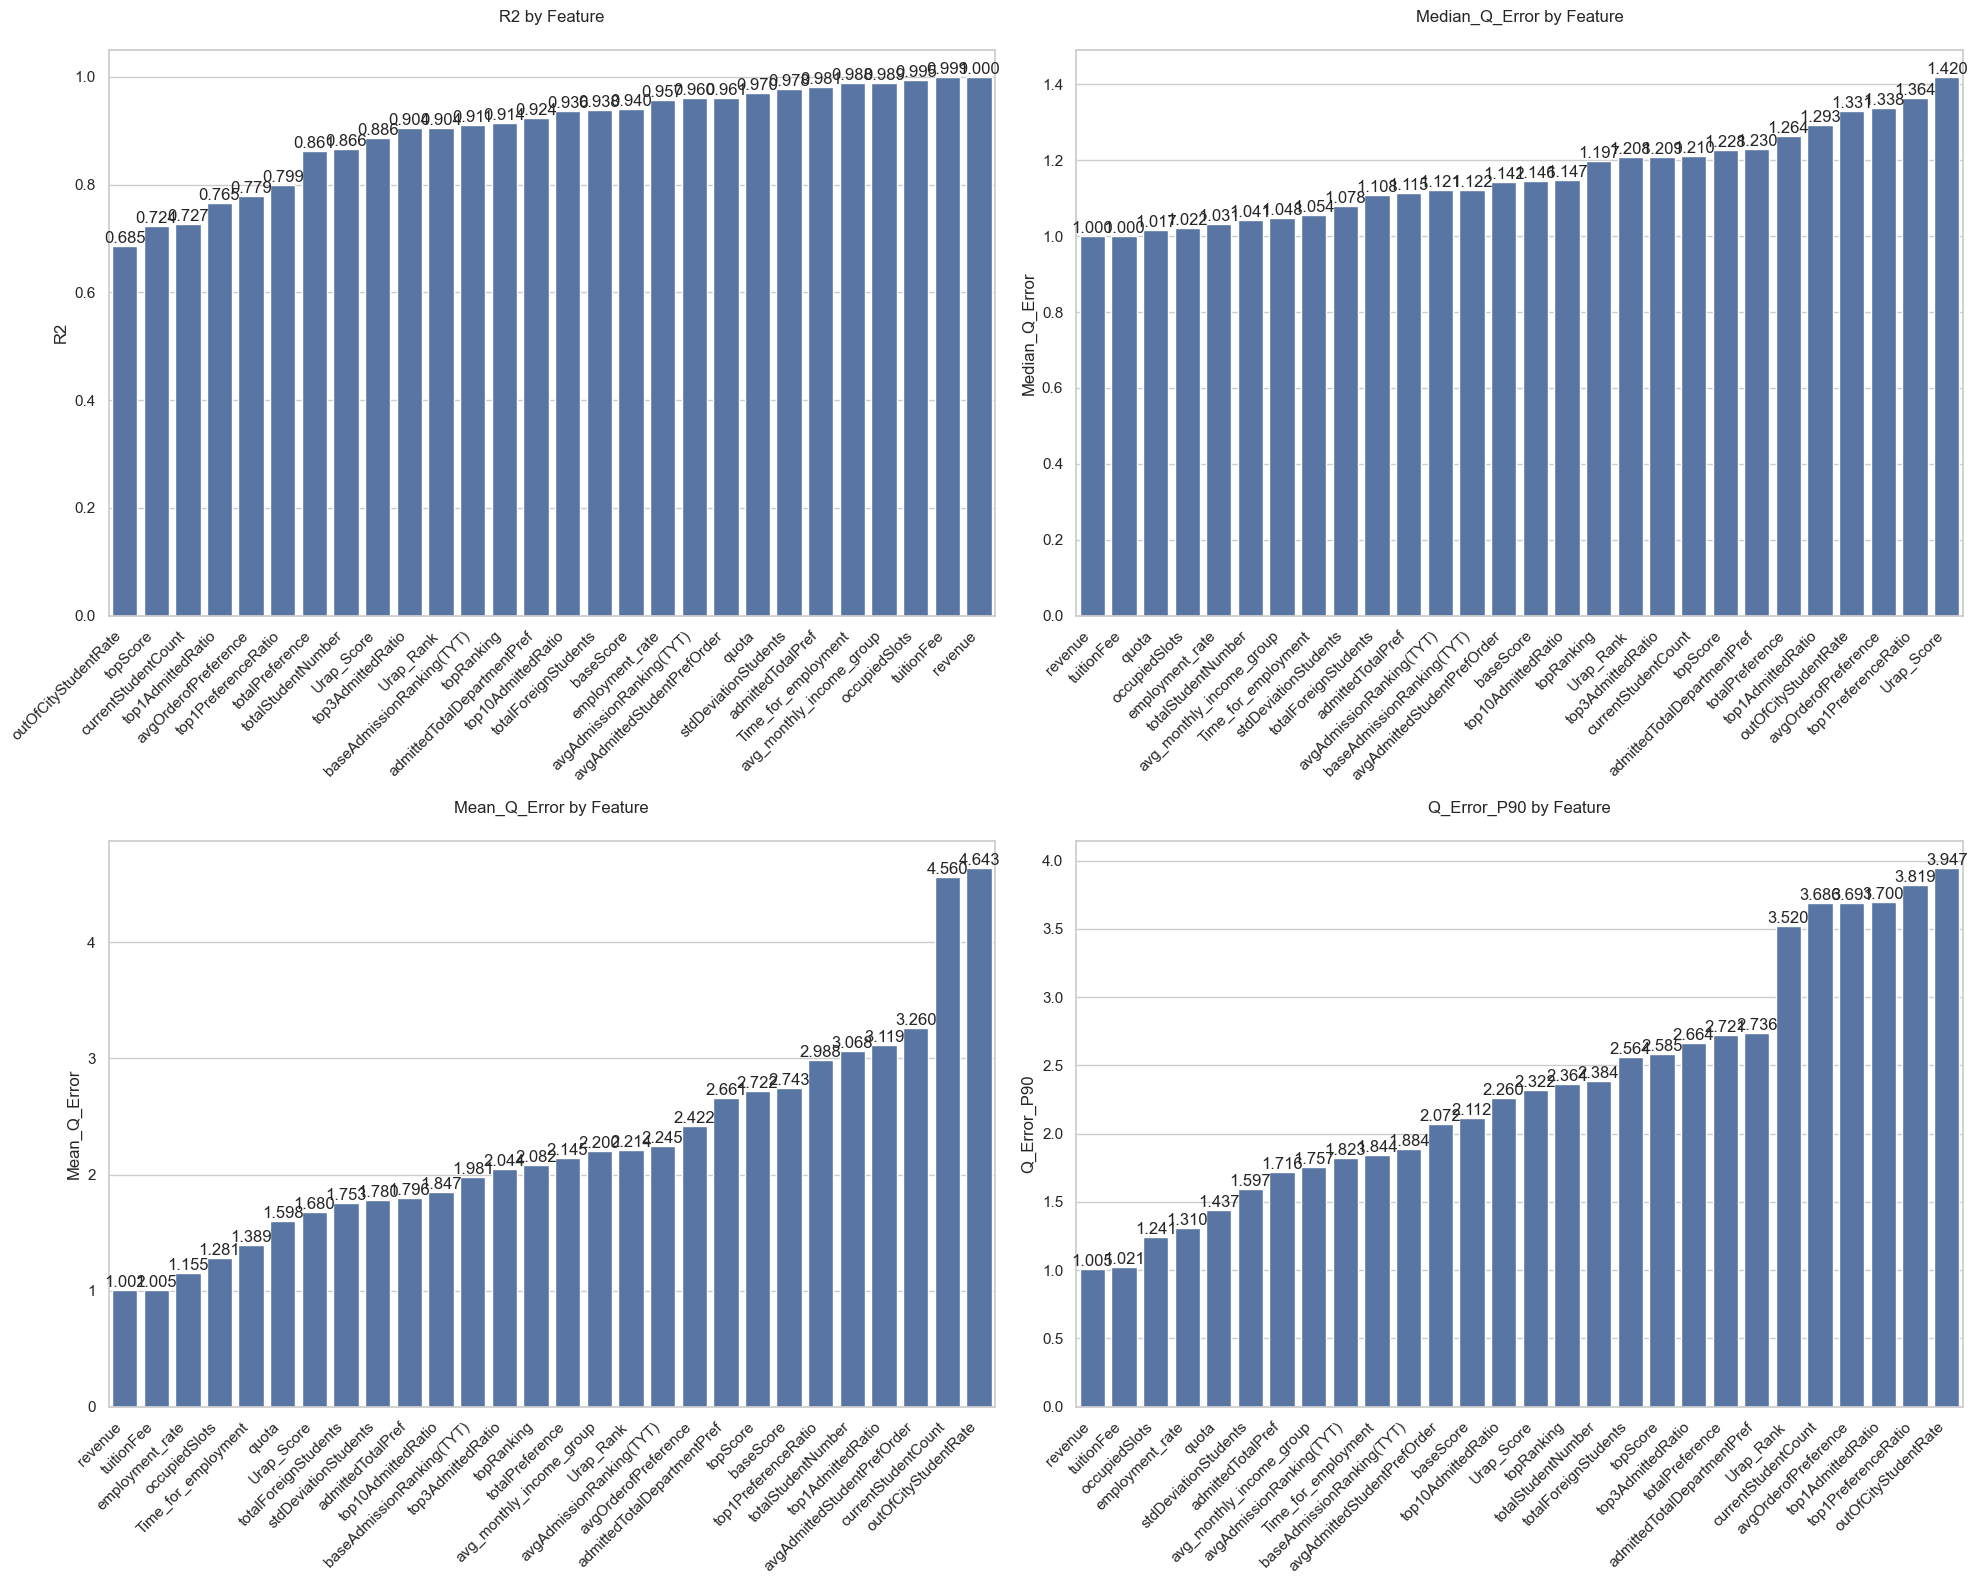

Visualizations have been displayed.


In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_metrics(metrics_df):
    # Set seaborn style
    sns.set(style='whitegrid')
    
    # Create subplots for each metric
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    metrics = ['R2', 'Median_Q_Error', 'Mean_Q_Error', 'Q_Error_P90']
    
    # Flatten axes for easier iteration
    axes = axes.flatten()
    
    for idx, metric in enumerate(metrics):
        # Sort values for better visualization
        sorted_data = metrics_df.sort_values(by=metric, ascending=True)
        
        # Create bar plot
        sns.barplot(
            data=sorted_data,
            x='Feature',
            y=metric,
            ax=axes[idx]
        )
        
        # Rotate x-axis labels for better readability
        axes[idx].set_xticklabels(axes[idx].get_xticklabels(), rotation=45, ha='right')
        
        # Set titles and labels
        axes[idx].set_title(f'{metric} by Feature', pad=20)
        axes[idx].set_xlabel('')
        
        # Add value labels on top of bars
        for i, v in enumerate(sorted_data[metric]):
            axes[idx].text(
                i, v, f'{v:.3f}',
                ha='center', va='bottom'
            )
    
    # Adjust layout
    plt.tight_layout()
    
    # Display plot
    plt.show()

# Read the metrics CSV
metrics_df = pd.read_csv('xgb_metrics_detailed.csv')

# Create visualizations
plot_metrics(metrics_df)
print("Visualizations have been displayed.")
